# Section II - Bloqade tutorial

This document is a elementary introduction to programming neutral-atom analog quantum processors with Bloqade. The goal is to bring the reader "from 0 to 1", demonstrating in a single step how simple solving problems can be with Bloqade. 

We will pick up from where we stopped in the previous notebook, and consider how to bring together geometry and time control (steps 1 and 2 of encoding a problem in neutral atoms, as per the previous notebook), and then initialize states, eovlve, and measure observables (steps 3 to 5) for some specific problems

*disclaimer: note that Julia is slow the first time it runs a problem, due to pre-compilation. It will run fast after a first run through a calculation.*

### Preparations

To get started let's include some packages that will be useful.

In [1]:
using Graphs
using Bloqade
using Random
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

# I. Quantum Dynamics

Let's start by looking at the dynamics of a single qubit in the presence of a Rabi term.

We start by creating a register of a single atom,

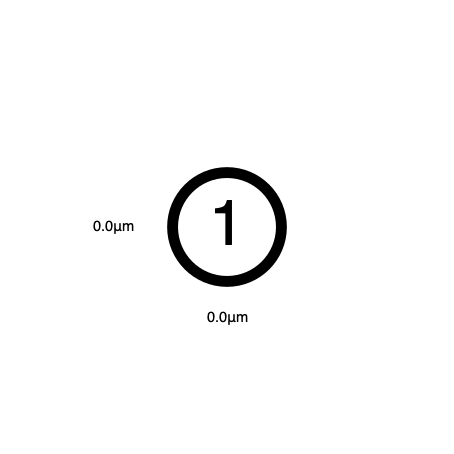

In [2]:
atom1 = AtomList([(0.0, 0.0)])

and a Hamiltonian with a Rabi drive $\Omega=2$MHz

In [3]:
h1 = rydberg_h(atom1; Δ = 0, Ω = 2π * 2)

nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|r_i-r_j|^6 n_i n_j
├─ [+] 2π ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


The above we learned on the previous section. Now we move to step 3. We initialize our register in the $|\psi(0)\rangle=|0\rangle$ state to set boundary conditions

In [4]:
reg1 = zero_state(1)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 1/1
    nlevel: 2

Now let's evolve, step 4. This is our first time doing it! Since we are interested in dynamics here, we have to work a little. We pick a total time of $1.5 \mu s$, discretize time in tiny pieces $\delta t=10^{-2}$ for numerical evolution, and pick a method to solve the time evolution (here we are using `KrylovEvolution`)

In [5]:
total_time = 1.5
clocks = 0.0:1e-2:total_time
prob1 = KrylovEvolution(reg1, clocks, h1)
density1 = zeros(1, length(clocks));

for info in prob1
    density1[1, info.step] = rydberg_density(info.reg, 1)
end

And step 5, let's measure something. Here, we plot the evolution of the mean value of the Rydberg number. We see, as expected $n(t)=\cos^2 (\Omega t)$

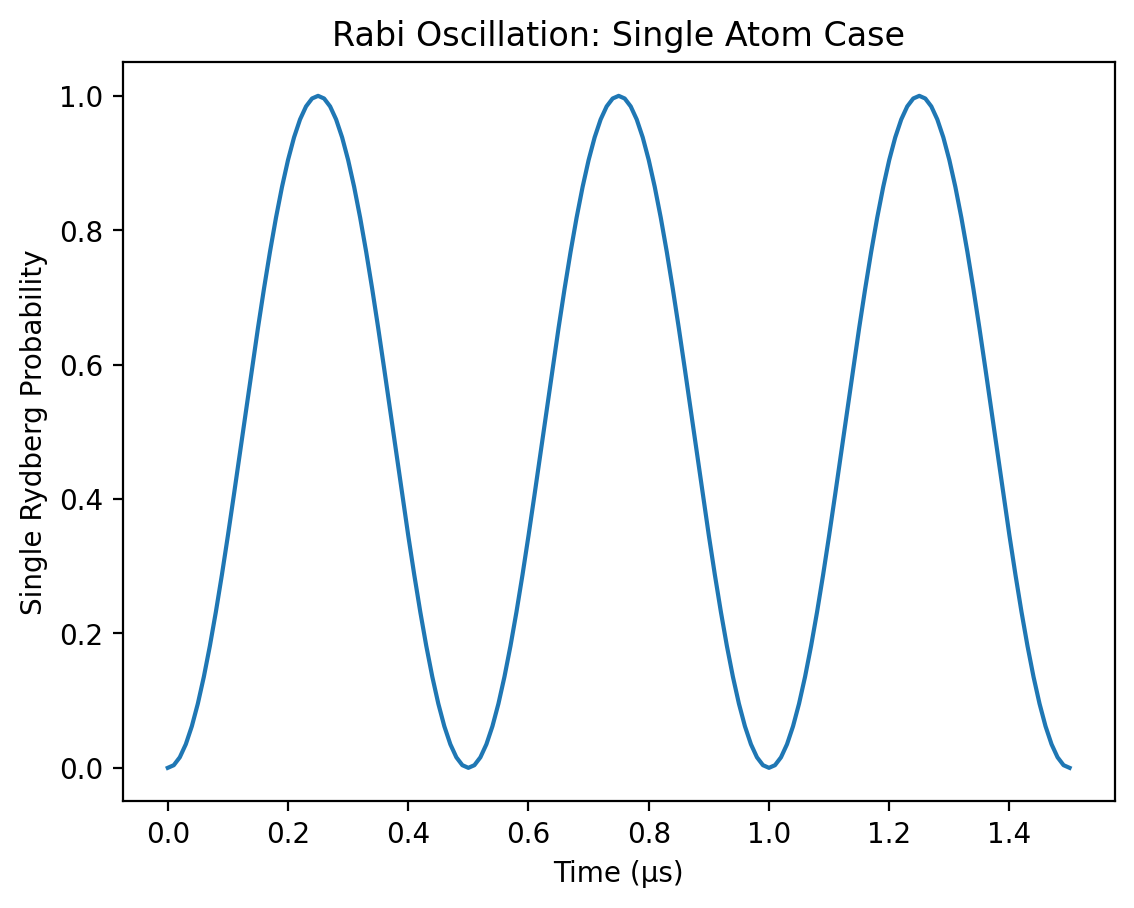

In [6]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Single Rydberg Probability")
ax.set_title("Rabi Oscillation: Single Atom Case")
fig

## Exercise:

Let's do this again for 2 atoms. Below we have a simple approach to it.

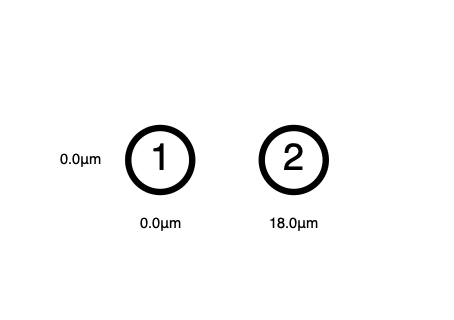

In [7]:
separation=3.0
atom2 = generate_sites(ChainLattice(), 2, scale = 18.0)

In [8]:
h2 = rydberg_h(atom2; Δ = 0, Ω = 2π * 2)

reg2 = zero_state(2)

total_time = 1.5
clocks = 0.0:1e-2:total_time
prob2 = KrylovEvolution(reg2, clocks, h2)
density2 = zeros(2, length(clocks));

for info in prob2
    for i in 1:2
        density2[i, info.step] = rydberg_density(info.reg, i)
    end
end
density2 = sum(density2, dims = 1);


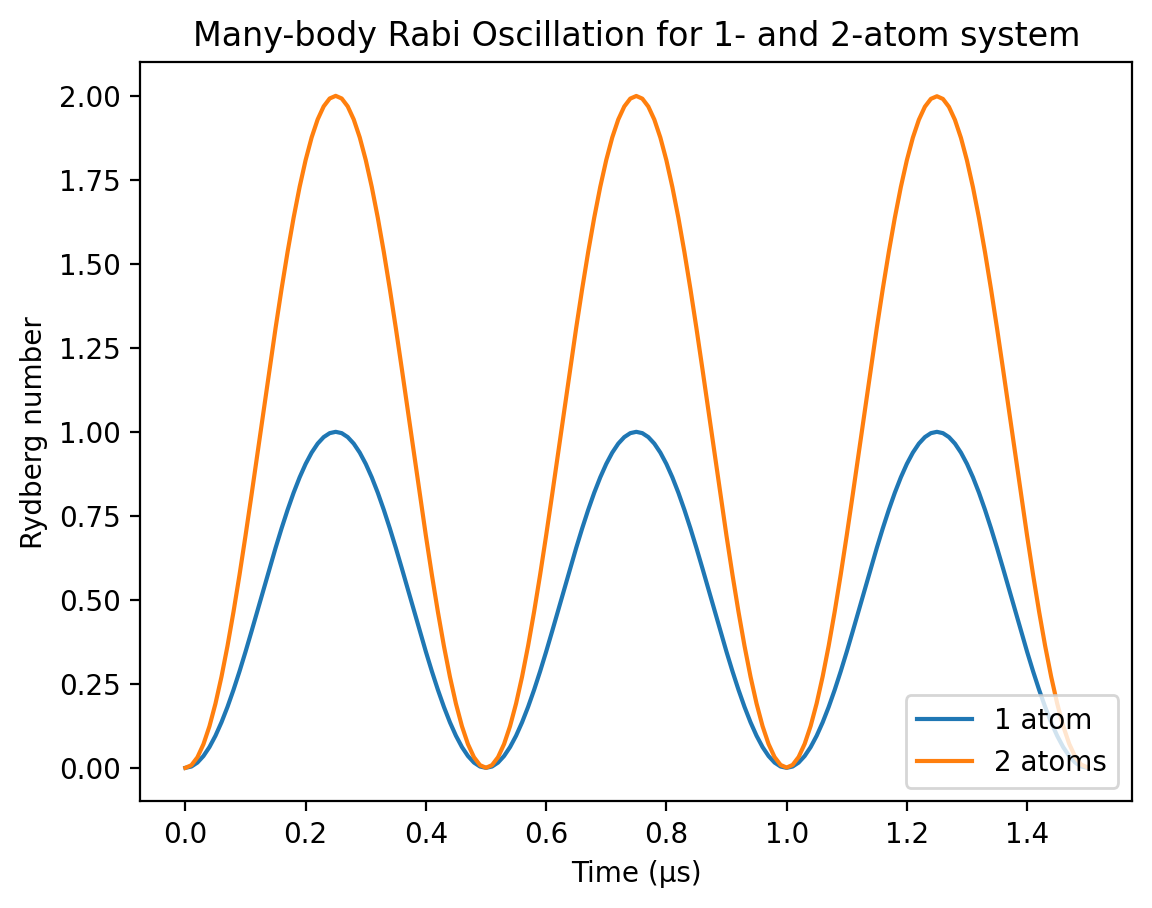

In [9]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.plot(clocks, density2[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Rydberg number")
ax.set_title("Many-body Rabi Oscillation for 1- and 2-atom system")
ax.legend(["1 atom", "2 atoms"], loc = "lower right")
fig

Now the main exercise. Run the calculation for different values of the qubit separation. What do you observe in the Rabi frequency? What do you think is going on? Which states form the time-dependent state manifold?

# II. Application Examples

## The Maximum Independent Set
To make the above concrete, let's do an end-to-end example, using Bloqade to solve a paradigmatic problem of graph theory: the Maximum Independent Set (MIS). Given a graph with nodes (say we color them in white) and some edges between them, to find an MIS is to color the largest possible subset of nodes (say in red) not connected among themselves by edges. Our MIS should simply be a set of red nodes with no edges between them. How do we solve these with atoms?

To encode our problem, we will imagine that states at $| 0 \rangle$ are white and $| 1 \rangle$ are red. Step 1 then is to define atomic positions with the atoms shaping the nodes of a graph. For simplicity, we take here a $4 \times 4$ lattice, with atomic spacing of $4.5\mu m$, and we drop 20% of the positions at random to keep things interesting.

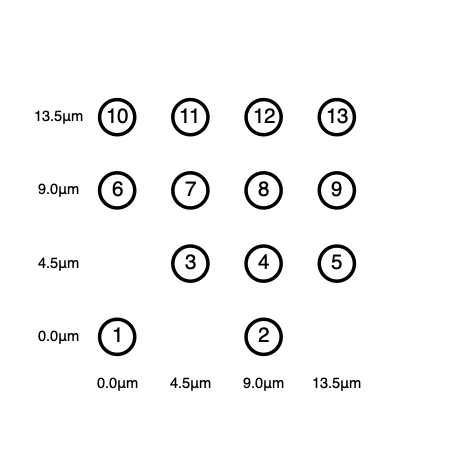

In [10]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

So very well, the above should represent the nodes of a graph. But how do we define edges? As mentioned, two atoms that are too close together are blocked from being both in the $| 1 \rangle$, or red, state. So we will abstract the atoms that are positioned closer than a "blockade radius" distance $R_b$, under which 2 qubits cannot be simultaneously $1$, to be connected by an edge.

Determining the $R_b$ scale is somewhat a tricky task. A good practice is to first determine an $R_{min}$, defining the minimal radius in which one would like to have atoms blocking each other, and an $R_{max}$, defining a radius after which one does not want atoms blocking each other. Then, a nice way to fix the desired blockade scale is to take the geometric mean $R_b=\sqrt{R_{min}R_{max}}$. 

Let's imagine we want the atoms to be connected to their first and second neighbors (when in a square lattice, this is known as a "king's graph", alluding to chess). In this case, $R_{min}=\sqrt{2}a$ -- blocking the first and second neighbors -- and $R_{max}=2a$ -- so not blocking third neighbors and beyond. 

Algother, we want $R_b=\sqrt{2\sqrt{2}}a\approx 7.57\mu m$.

In [11]:
Rb=sqrt(2*sqrt(2))*a

7.568067737283432

Let's plot and check

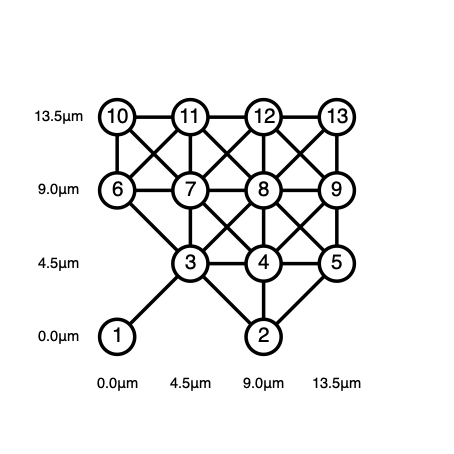

In [12]:
Bloqade.plot(atoms, blockade_radius = Rb)

Very well. Moving to step 2! We need to fix the algorithm. To solve the MIS in the graph above, this is not complicated. Adding a global heavy weight $\Delta$ to all sites should favor all qubits to be on state $| 1 \rangle$, while the Rydberg blockade should do, by itself and without need of our own control, the job of enforcing the constraint of no neighboring red nodes. The caveat is that the choice of parameters $\Delta$ and $\Omega$ is actually tied to the blockade radius, as we learned on Section I of the notes. 

So we can imagine initializing the graph with all states painted white, $| 0 \rangle$, and evolving a very negative global $\Delta$ towards a positive value, with a finite $\Omega$ meanwhile to enable qubit flips from $0$ to $1$. Since the state we are looking for is classical, we may as well turn $\Omega$ off at the end of the protocol, which also facilitates fixing of the blockade radius: it will simply be defined by $\Delta$  as $R_b = (C_6/\Delta)^{1/6}$, where $C_6=2\pi \times 862690\, \text{MHz}\, \mu \text{m}^6$. The typical choice of $\Omega$ is to make it as large as possible; it helps on the quantum scrambling of states via bit flips and, in some sense, defines a clock speed of operations during the protocol. Ramping $\Delta$ slowly to its correct final value, then, defines an adiabatic protocol to solve the MIS problem.

Here is how we do that with Blockade, using piecewise linear time traces for the Hamiltonian parameters.

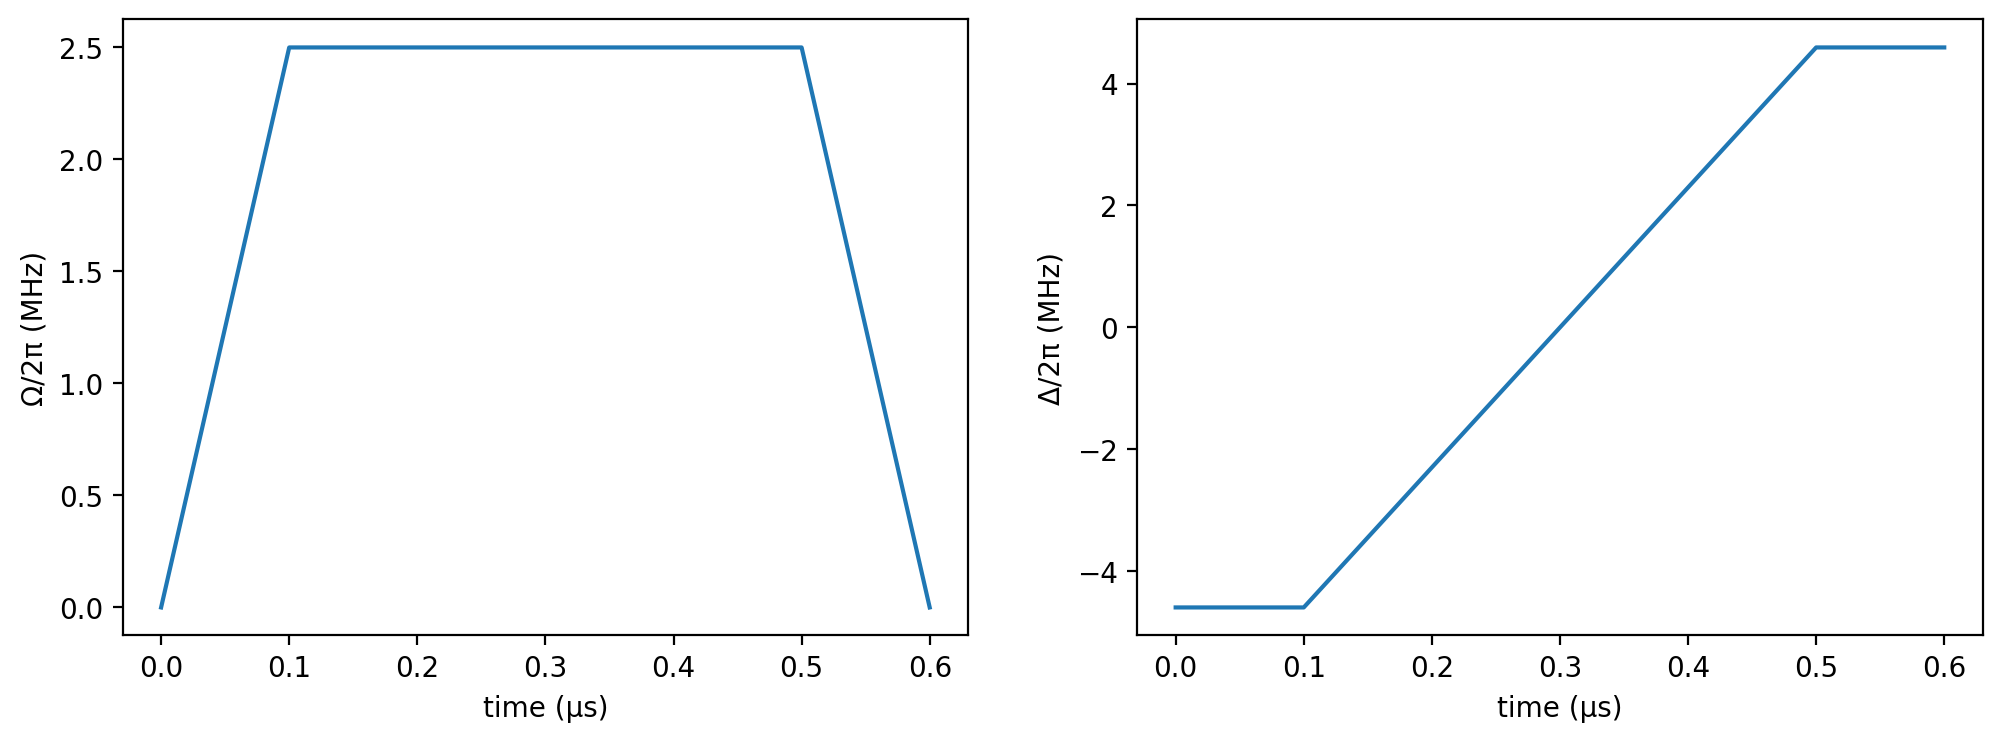

In [13]:
#Total evolution time
T_max = 0.6

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
ϕ = piecewise_constant(clocks=[0.0,T_max], values= [0.0]); #this is not necessary. Here for later use

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Optimizing these time traces can improve the convergence and likelihood of finding the MIS, but this will do for now. 

We initialize the problem with the parameters above, including a "zero_state" initial register for the Hamiltonian's qubits.

In [14]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);

To emulate the time evolution, here goes the syntax

In [15]:
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 2.563 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: CompositeAlgorithm{Tuple{Vern9{Static.False,…}, Rodas5{0,false,…}},…}((Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), Rodas5{0,false,…}(nothing, OrdinaryDiffEq.DEFAULT_PRECS)), AutoSwitch{Vern9{Static.False,…}, Rodas5{0,false,…}, Rational{Int64}, Int64}(Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), Rodas5{0,false,…}(nothing, OrdinaryDiffEq.DEFAULT_PRECS), 10, 3, 9//10, 9//10, 2, false, 5))
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10

We are done. Now it is just a matter of enjoying the results by asking questions. For example, the 10 most probable basis states contributing to $| \psi(t=T_{Max}) \rangle$ are

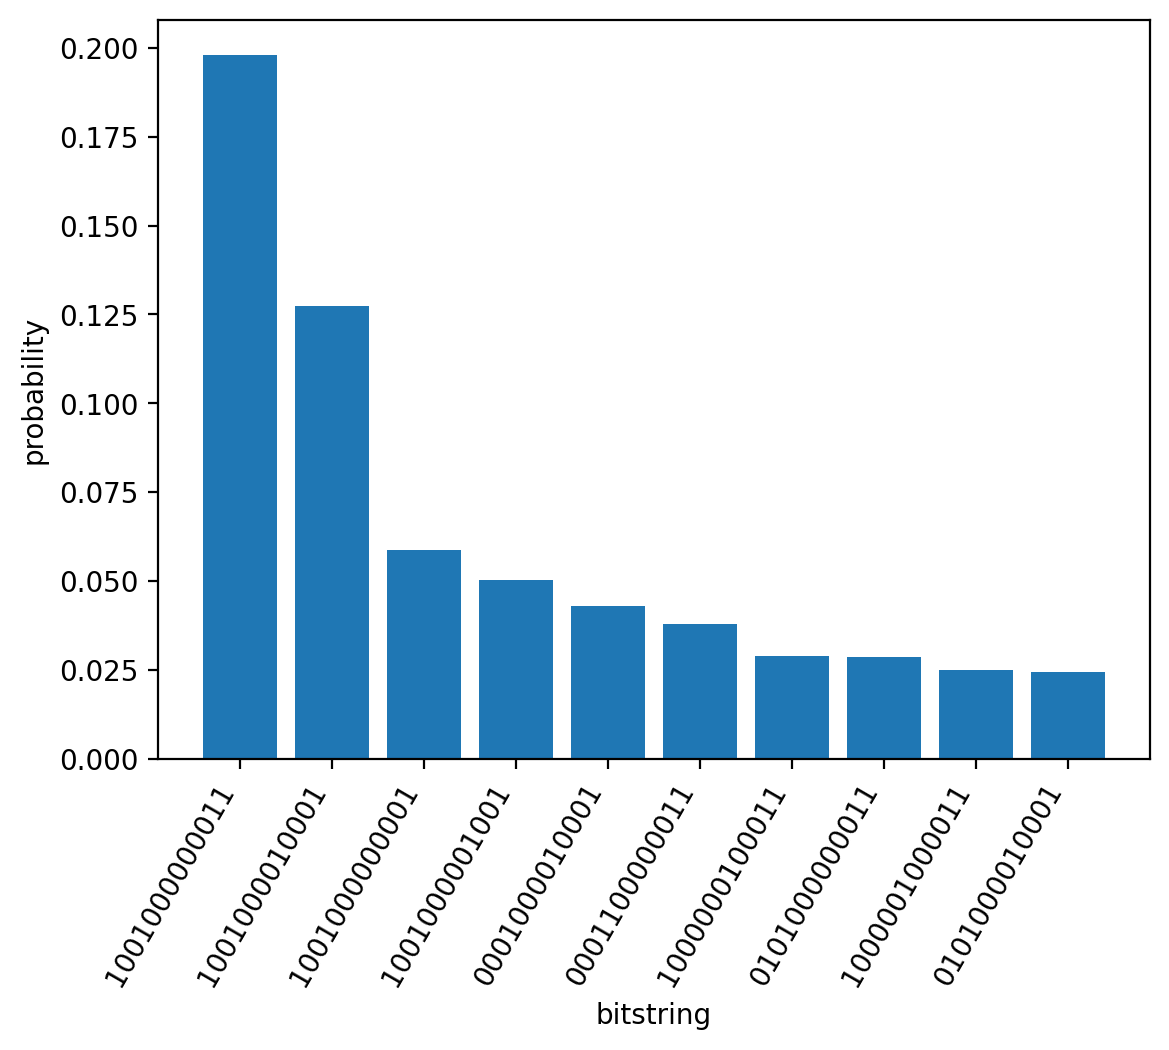

In [16]:
bitstring_hist(prob.reg; nlargest = 10)

We already see that a couple of them have larger probability than the others. Do they correspond to MIS? At this level, we can check by eye. Here are some plots of the solutions (i.e., a graph colored according to the labels of the states found above)

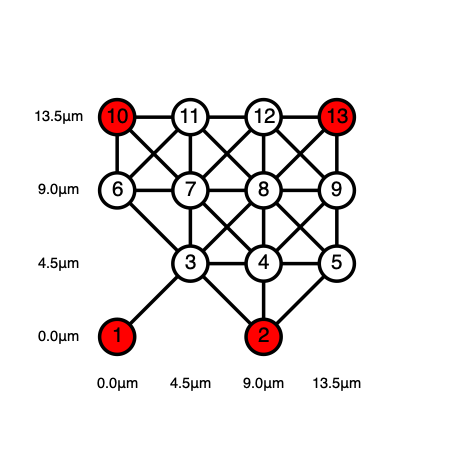

In [17]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

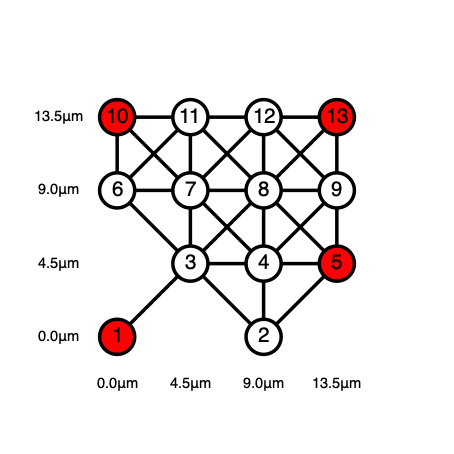

In [18]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

But note the 3rd most-likely bit string does **not** correspond to an MIS.

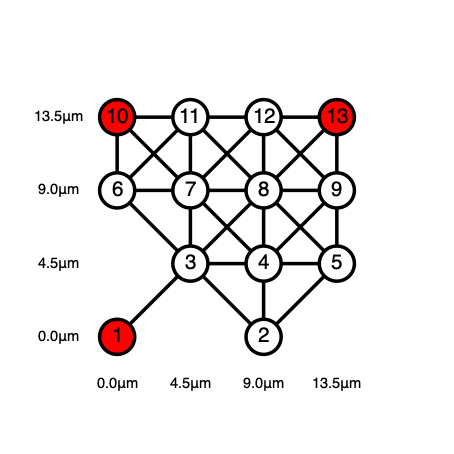

In [19]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])

This is an IS for sure, but not the maximum. Usually these solutions are called "|MIS|-1", and are actually quite important to study algorithmic performance. Other violations of the MIS would also be possible, including double connected excitations; these can also be improved into sub-optimal IS solutions via classical post-processing.

### Exercise:
Redo the process above to solve the MIS for the graph from our handout

## Checkerboards!

Following the lecture discussion, let's try to prepare a checkerboard state

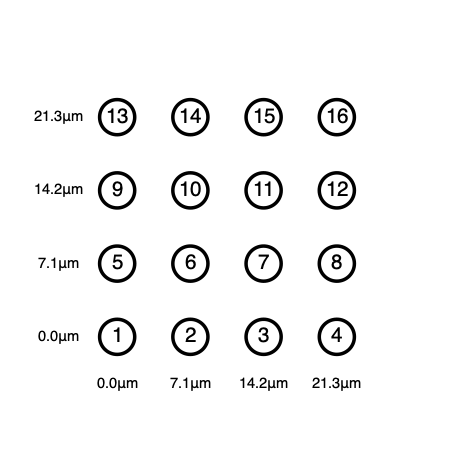

In [10]:
Random.seed!(2)
a=7.1
atoms = generate_sites(SquareLattice(), 4,4; scale = a)

pick a blockade radius according to first-neighbor 

In [11]:
Rb=sqrt(sqrt(2))*a

8.44337051651932

which means

In [12]:
Rb/a

1.189207115002721

Well into the good height in the y-axis of the phase diagram on slide 11 of Section II's slides.

Let's check if we are defining things properly looking at the lattice:

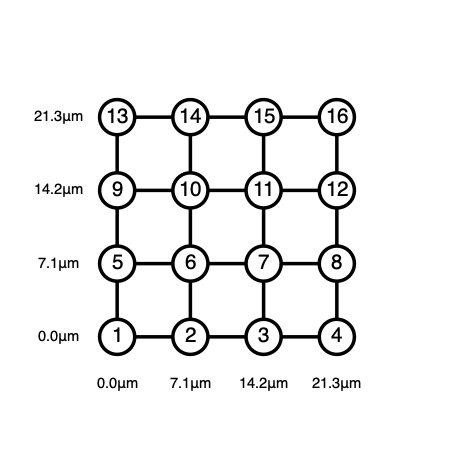

In [13]:
Bloqade.plot(atoms, blockade_radius = Rb)

Sounds like we are doing well!

Now the actual inter-atomic distance affects the energy scales at play, and our $\Omega_{max}=2\pi*2.5=15.7$ Mhz. So we better check that we can get a Rabi frequency on the hardware that matches this blockade radius:

In [14]:
C6 = 2π * 862690;
Ω_max= C6 / Rb^6

14.960273953348784

We seem to be all good! Fixing the x-axis amounts to then picking a good detuning which we will fix at $\Delta/\Omega=2.5$. Then, Let's create the algorithm

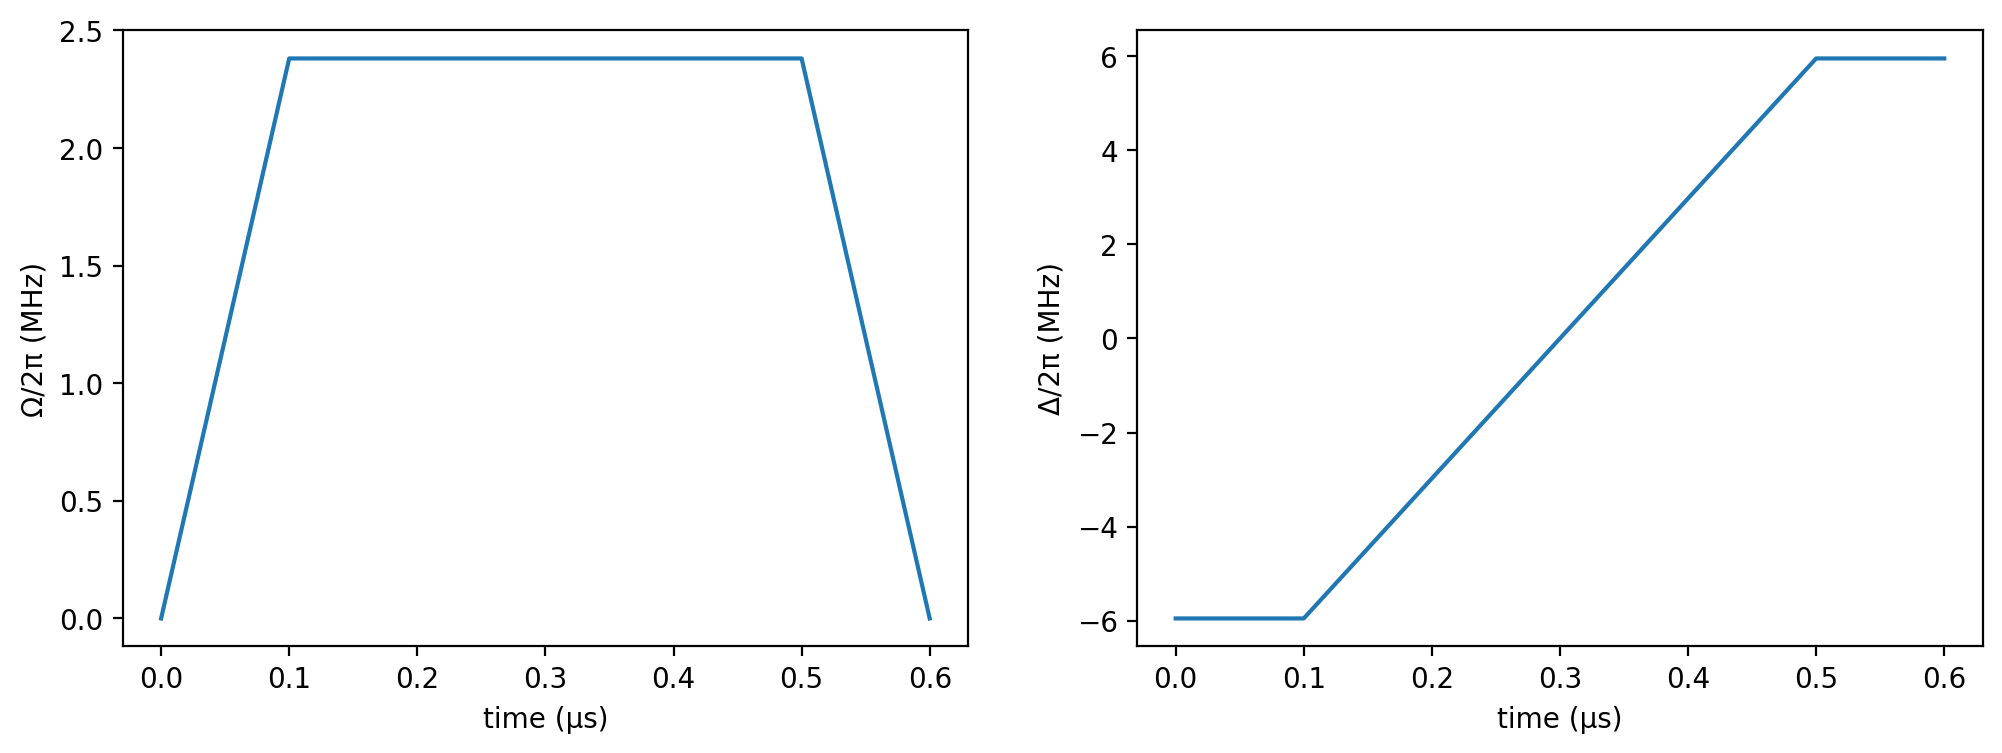

In [15]:
#Total evolution time
T_max = 0.6

Δ_max = 2.5*Ω_max

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
ϕ = piecewise_constant(clocks=[0.0,T_max], values= [0.0]); #this is not necessary. Here for later use

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Now run!

In [16]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);

emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 25.000 MiB
    expression:
nqubits: 16
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: CompositeAlgorithm{Tuple{Vern9{Static.False,…}, Rodas5{0,false,…}},…}((Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), Rodas5{0,false,…}(nothing, OrdinaryDiffEq.DEFAULT_PRECS)), AutoSwitch{Vern9{Static.False,…}, Rodas5{0,false,…}, Rational{Int64}, Int64}(Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), Rodas5{0,false,…}(nothing, OrdinaryDiffEq.DEFAULT_PRECS), 10, 3, 9//10, 9//10, 2, false, 5))
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-1

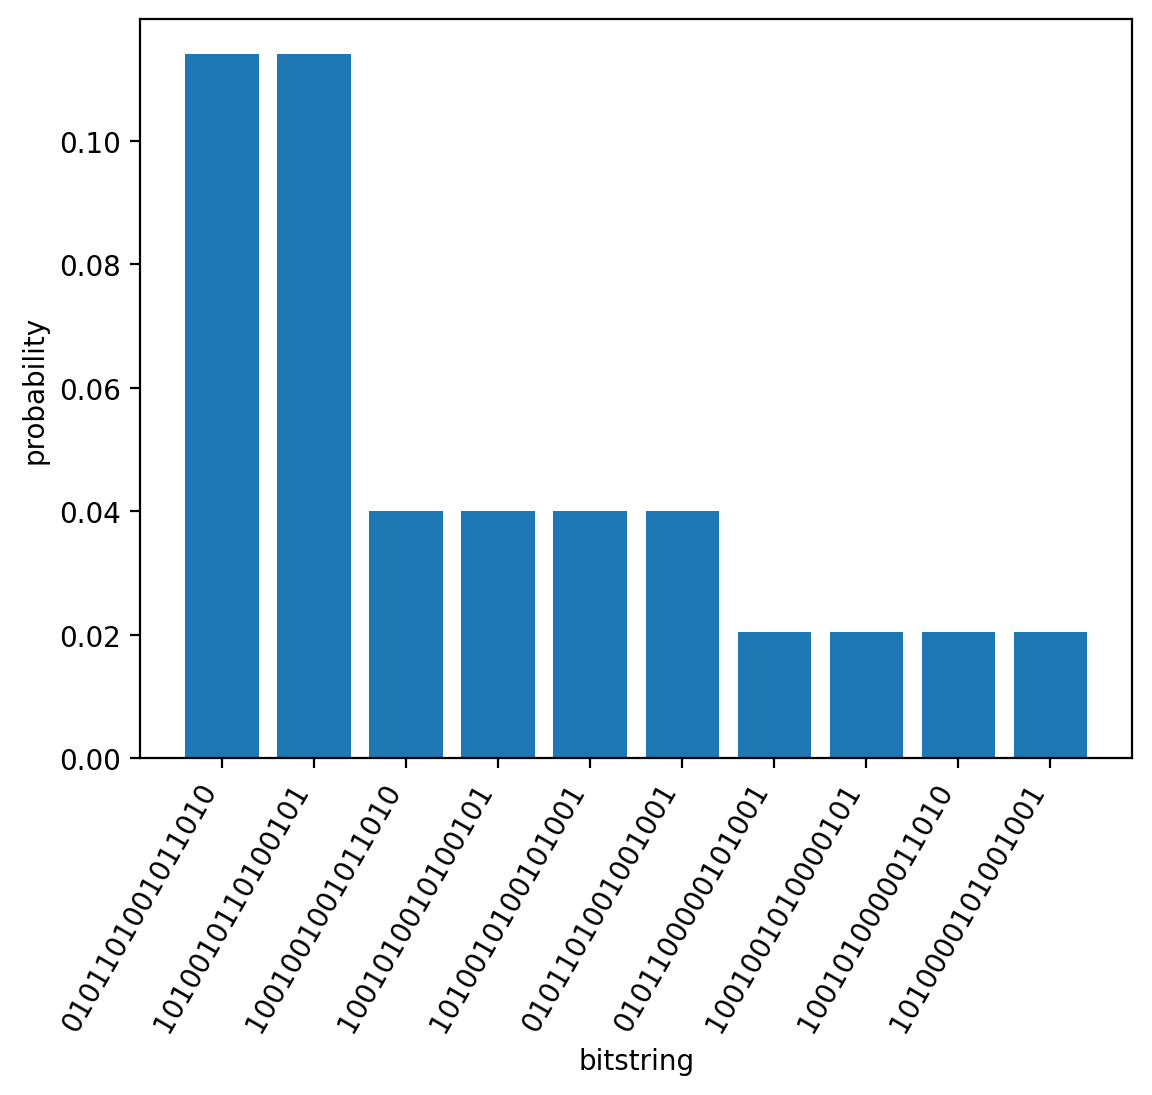

In [17]:
bitstring_hist(prob.reg; nlargest = 10)

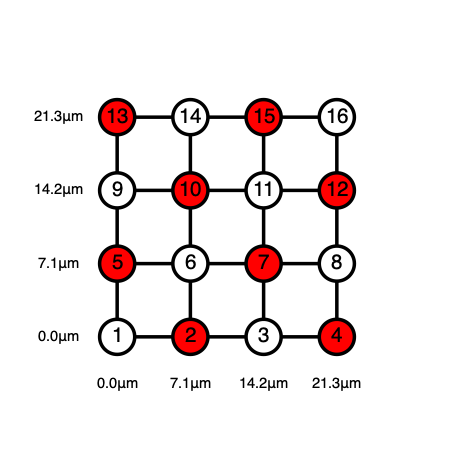

In [18]:
best_bit_strings = most_probable(prob.reg, 4)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])


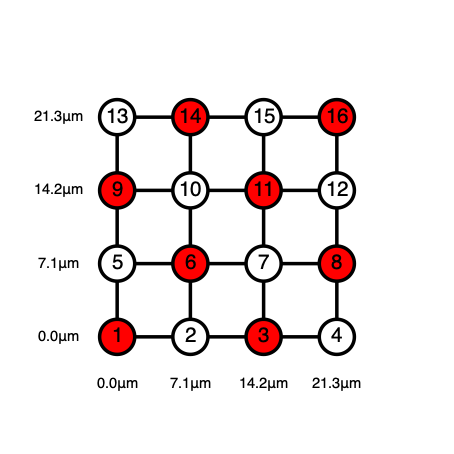

In [19]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

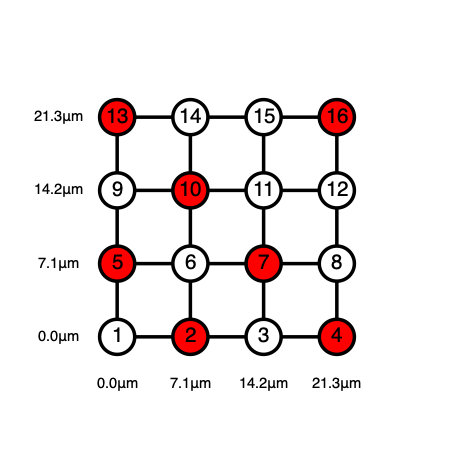

In [20]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])


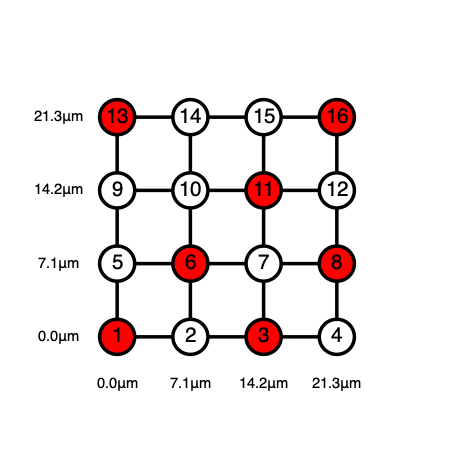

In [21]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[4]])

### Exercise

Rerun the code above for other phases on the square lattice

# III. Exporting to Aquila/Braket

So we are pros of simulating problems with Bloqade. But we all want to see how a real quantum device performs. Also, Bloqade will be limited to a few 10s of qubits on most computers, while Aquila is waiting for us on the cloud with up to 256 qubits. Gladly, Bloqade can export jobs to Aquila via the Braket service. Here we go step-by-step on the key points.

Let's stick to our MIS example above. To run the problem on Aquila, the first step is to convert the Hamiltonian from its standard Bloqade format to one that can be taken by the Amazon Braket service. We need the `Bloqade_schema` package, and then use `hardware_transform` to make the convertion

In [29]:
using BloqadeSchema


transformed_h, transform_info = hardware_transform(h_kings);

We were careful enough to make geometric and waveform choices that match hardware requirements. Still, one should always check if the transformed Hamiltonian is acceptable given hardware constraints. We can test that via the function `validate`

In [30]:
validate(transformed_h)

The following validation violations occured:



There we go! All should be working. To submit jobs to Aquila, all one needs now is their AWS Braket credentials, which can be generated from the `AWS` Braket package, and the function `submit_to_braket`, which takes as input the desired Hamiltonian, the number of shots for the experiment, and, of course, the credentials. 

_Note: `submit_to_braket` can take as input the original Bloqade Hamiltonian as well, before transforming.`hardware_transform` is invoked automatically to make sure the Hamiltonian satisfies the hardware requirements. Still, the process of transforming and validating a Hamiltonian by hand is advised, to ensure calculations don't go wrong._

In [ ]:
using AWS

access_key_id = "your_access_key_id"
secret_key = "your_secret_key"
token = "your_token"

credentials = AWS.AWSCredentials(access_key_id, secret_key, token)

task = submit_to_braket(transformed_h, 100; credentials=credentials)

And that is it! The final disclaimer is that once jobs have been sent to Braket, the data that comes back is not really part of the Bloqade infrastructure. To interact with the results, one has to rely on the `Braket.jl` package and functions like `state` (that will tell you if your task ran, is in the queue, was cancelled, or failed) and `result` or `get_measurements`, to read the actual data. For more info, take a lookt at  [Braket.jl's documentation](https://github.com/awslabs/Braket.jl)



# Conclusion

This is a wrap! Congratulations, you are a Bloqade initiate!